In [241]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import stats, signal
import random
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools

setName = "set4-puttogether"
# Each accelerometer log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        
        # sensorTimestampMs comes from the Arduino function 
        # https://www.arduino.cc/reference/en/language/functions/time/millis/
        # which returns the number of milliseconds passed since the Arduino board began running the current program.
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # Calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
    def pad_with_mean(self, headPadLength, tailPadLength):
        self.signalLengthBeforePadding = len(self.x)
        
        self.x_padded = np.pad(self.x, (headPadLength, tailPadLength), 'mean')
        self.y_padded = np.pad(self.y, (headPadLength, tailPadLength), 'mean')
        self.z_padded = np.pad(self.z, (headPadLength, tailPadLength), 'mean')
        self.mag_padded = np.pad(self.mag, (headPadLength, tailPadLength), 'mean')

    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_processed_data(self):
        return {"x_p":self.x_p, "y_p":self.y_p, "z_p":self.z_p, "mag_p":self.mag_p}

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

# Container for a single set of gestures and trials
class GestureSet:
    
    def __init__(self, gesture_log_path, map_gestures_to_trials):
        self.path = gesture_log_path
        self.map_gestures_to_trials = map_gestures_to_trials 

    # returns the longest trial (based on num rows recorded and not clock time)
    def get_longest_trial(self):
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    
    # returns the base path
    def get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    # returns the number of gestures
    def get_num_gestures(self):
        return len(self.map_gestures_to_trials)
    
    # returns trials for a gesture name
    def get_trials_for_gesture(self, gesture_name):
        return self.map_gestures_to_trials[gesture_name]
    
    # creates an aggregate signal based on *all* trials for this gesture
    # TODO: in future could add in an argument, which takes a list of trial nums
    # to use to produce aggregate signal
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
        first_trial_signal = None
        
        max_length = -1
        for trial in trials:
            trial_signal = getattr(trial.accel, signal_var_name)
            if max_length < len(trial_signal):
                max_length = len(trial_signal)
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)
                
                array_length_diff = max_length - len(trial_signal_mod)
                trial_signal_mod = np.pad(trial_signal_mod, (0, array_length_diff), 'mean')  

                aggregate_signal = trial_signal_mod
                first_trial_signal = trial_signal_mod
            else:

                cur_trial = trials[i]
                cur_trial_signal = getattr(trial.accel, signal_var_name) 
                trial_signals_original.append(cur_trial_signal)
                
                array_length_diff = max_length - len(cur_trial_signal)
                cur_trial_signal_mod = np.pad(cur_trial_signal, (0, array_length_diff), 'mean') 

                cur_trial_signal_mod = get_aligned_signal_cutoff_and_pad(cur_trial_signal_mod, first_trial_signal)
                trial_signals.append(cur_trial_signal_mod)
                aggregate_signal += cur_trial_signal_mod
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    # Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
    # different number. We should have the same number of trials across all gestures)
    def get_min_num_of_trials(self):
        minNumTrials = -1 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            if minNumTrials == -1 or minNumTrials > len(trialSet):
                minNumTrials = len(trialSet)
        return minNumTrials

    # returns the total number of trials
    def get_total_num_of_trials(self):
        numTrials = 0 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    # get random gesture name
    def get_random_gesture_name(self):
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    # get random trial
    def get_random_trial(self):
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    # returns a sorted list of gesture names
    def get_gesture_names_sorted(self):
        return sorted(self.map_gestures_to_trials.keys())
    
    # prettify the str()
    def __str__(self):
         return "'{}' : {} gestures and {} total trials".format(self.path, self.get_num_gestures(), self.get_total_num_of_trials())
        

In [242]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        
        # parse filename into meaningful parts
        # print(csvFilename)
        filenameNoExt = os.path.splitext(csvFilename)[0];
        
        filenameParts = filenameNoExt.split("_")
        gestureName = None
        timeMs = None
        numRows = None
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
            
        # Added this conditional on May 15, 2019 because Windows machines created differently formatted
        # filenames from Macs. Windows machines automatically replaced the character "'"
        # with "_", which affects filenames like "Midair Zorro 'Z'_1556730840228_206.csv"
        # which come out like "Midair Zorro _Z__1557937136974_211.csv" instead
        if '__' in filenameNoExt:
            filename_parts1 = filenameNoExt.split("__")
            gestureName = filename_parts1[0]
            gestureName = gestureName.replace('_',"'")
            gestureName += "'"
            
            filename_parts2 = filename_parts1[1].split("_")
            timeMs = filename_parts2[0]
            numRows = filename_parts2[1]
        else:
            filenameParts = filenameNoExt.split("_")
            gestureName = filenameParts[0]
            timeMs = filenameParts[1]
            numRows = int(filenameParts[2])
        
        # print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc. in order)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Perform some preprocessing
    listSamplesPerSec = list()
    listTotalSampleTime = list()
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Padding all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 

            listSamplesPerSec.append(trial.accel.samplesPerSecond)
            listTotalSampleTime.append(trial.accel.sampleLengthInSecs)
            
            # preprocess signal before classification and store in new arrays
            trial.accel.x_p = preprocess(trial.accel.x, maxArrayLength)
            trial.accel.y_p = preprocess(trial.accel.y, maxArrayLength)
            trial.accel.z_p = preprocess(trial.accel.z, maxArrayLength)
            trial.accel.mag_p = preprocess(trial.accel.mag, maxArrayLength)
            
            
    print("Avg samples/sec across {} sensor files: {:0.1f}".format(len(listSamplesPerSec), sum(listSamplesPerSec)/len(listSamplesPerSec)))
    print("Avg sample length across {} sensor files: {:0.1f}s".format(len(listTotalSampleTime), sum(listTotalSampleTime)/len(listTotalSampleTime)))
    print()
    return mapGestureNameToTrialList

# Performs some basic preprocesing on rawSignal and returns the preprocessed signal in a new array
def preprocess(rawSignal, maxArrayLength):
    meanFilterWindowSize = 3
    arrayLengthDiff = maxArrayLength - len(rawSignal)

    # CSE599 TODO: add in your own preprocessing here
    # Just smoothing the signal for now with a mean filter
    smoothed = np.convolve(rawSignal, np.ones((meanFilterWindowSize,))/meanFilterWindowSize, mode='valid')
    return smoothed

# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

# Helper function to align signals. 
# Returns a shifted signal of a based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of a based on cross correlation and padding
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    index_shift_abs = abs(index_shift - 1)
    a_shifted_cutoff = None
    if (index_shift - 1) < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs,), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# calculate zero crossings
# See: https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
# TODO: in future, could have a min_width detection threshold that ignores 
# any changes < min_width samples after an initial zero crossing was detected
# TODO: could also have a mininum height after the zero crossing (withing some window)
# to eliminate noise
def calc_zero_crossings(s):
    # I could not get the speedier solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    for ind in range(1, len(s)):
        next_pt = s[ind]
        
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossings.append(ind)
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = ind
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossings.append(ind)
            
        cur_pt = s[ind]
    return zero_crossings

In [243]:
# Load the data
root_gesture_log_path = './trainingData' # this dir should have a set of gesture sub-directories
print(get_immediate_subdirectories(root_gesture_log_path))
gesture_log_paths = get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None
for gesture_log_path in gesture_log_paths:
    
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Reading in:", path_to_gesture_log)
    map_gestures_to_trials = parse_and_create_gesture_trials(path_to_gesture_log)
    gesture_set = GestureSet(gesture_log_path, map_gestures_to_trials)
    map_gesture_sets[gesture_set.get_base_path()] = gesture_set
    if setName in gesture_log_path:
        selected_gesture_set = gesture_set
        
if selected_gesture_set is not None:
    print("The selected gesture set:", selected_gesture_set)

def get_gesture_set_with_str(str):
    for base_path, gesture_set in map_gesture_sets.items():
        if str in base_path:
            return gesture_set
    return None

['set2', 'set3-long', 'set4-puttogether', 'set1']
Reading in: ./trainingData/set2
Found 30 csv files in ./trainingData/set2
Found 2 gestures
Found 15 trials for 'LeftZ'
Found 15 trials for 'RightX'
Max trial length across all gesture is 'RightX' Trial 0 with 2281 sensor events. Padding all arrays to match
Avg samples/sec across 30 sensor files: 904.8
Avg sample length across 30 sensor files: 1.3s

Reading in: ./trainingData/set3-long
Found 10 csv files in ./trainingData/set3-long
Found 2 gestures
Found 5 trials for 'LeftZ'
Found 5 trials for 'RightX'
Max trial length across all gesture is 'RightX' Trial 2 with 2572 sensor events. Padding all arrays to match
Avg samples/sec across 10 sensor files: 887.4
Avg sample length across 10 sensor files: 1.7s

Reading in: ./trainingData/set4-puttogether
Found 10 csv files in ./trainingData/set4-puttogether
Found 2 gestures
Found 5 trials for 'RightX'
Found 5 trials for 'LeftZ'
Max trial length across all gesture is 'RightX' Trial 2 with 2081 sens

In [244]:
def topN_freqs(s, topN):
    sampling_rate = 77
    n = len(s)
    fft = np.fft.fft(s)
    freqs = np.fft.fftfreq(n)
    freqs = freqs * sampling_rate # convert normalized freq bins to our freq bins

    freqs = freqs[range(n//2)] # one side freq range
    fft = np.abs(fft)[range(n//2)] # one side freq range

#     Exclude the freq = 0 
    freqs = freqs[1:len(freqs)]
    fft = fft[1:len(fft)]
    
    # find the max frequency
    # you could modify this to find the top ~3-5 max frequencies
    

    topN_freqs = [freqs[idx] for idx in np.argsort(fft)[::-1][:topN]]
    topN_ffts = [fft[idx] for idx in np.argsort(fft)[::-1][:topN]]

    return {"freqs": topN_freqs, "ffts":topN_ffts}

def topN_peaks(s, topN):   
    peaks, _ = signal.find_peaks(s, )
    prominences = signal.peak_prominences(s, peaks)[0]
    widths = signal.peak_widths(s, peaks, rel_height=1)[0]
    topN_peaks = [peaks[idx] for idx in np.argsort(prominences)[::-1][:topN]]
    topN_prominences = [prominences[idx] for idx in np.argsort(prominences)[::-1][:topN]]
    topN_widths = [widths[idx] for idx in np.argsort(prominences)[::-1][:topN]]

    if len(topN_widths) < topN:
        topN_widths += list(np.zeros(topN - len(topN_widths)))
        topN_prominences += list(np.zeros(topN - len(topN_prominences)))
    return {"peaks": topN_peaks, "prominences": topN_prominences, "widths": topN_widths}





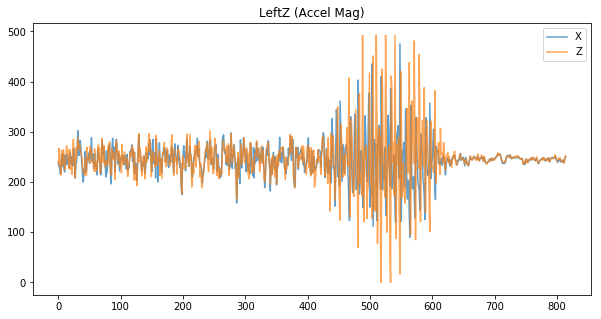

In [258]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(selected_gesture_set.map_gestures_to_trials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = selected_gesture_set.map_gestures_to_trials[randomGestureName]

trial = gestureTrials[0]

axes.plot(trial.accel.x, alpha=0.7, label="X")
axes.plot(trial.accel.z, alpha=0.7, label="Z")


# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


In [245]:
signal_x = selected_gesture_set.map_gestures_to_trials['RightX'][3].accel.x
signal_z = selected_gesture_set.map_gestures_to_trials['RightX'][3].accel.z

# b, a = sg.butter(4, 500. / (fr / 2.), 'low')
# x_fil = sg.filtfilt(b, a, x)
# play(x_fil, fr)
# fr= 887

# b, a = signal.butter(5, 0.9, 'high')
# x_fil = signal.filtfilt(b, a, signal_x)
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# ax.plot(signal_x, lw=1)
# ax.plot(x_fil, lw=1)

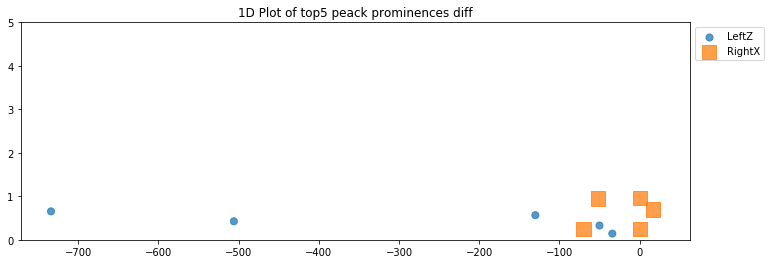

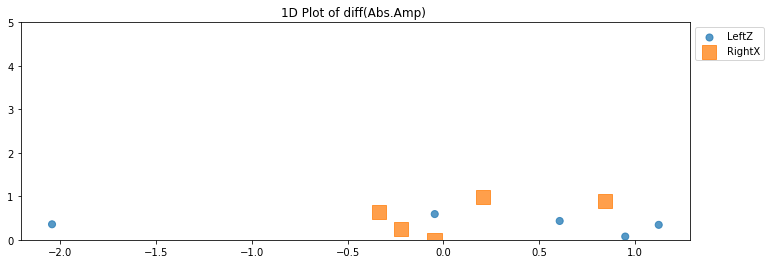

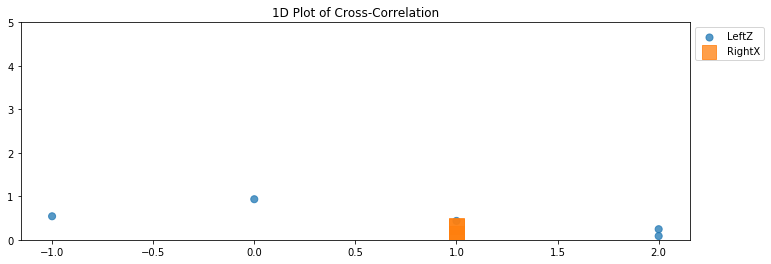

In [246]:
# first, let's graph some features along one dimension
# Brainstorm features
# - Length of signal
# - Max accel magnitude
# - Fundamental frequency
# - Top frequency
# - Intensity of top frequency
# - Top 5 frequency intensities (just plot which bins)
# - Average of values in the signal
# - Std deviation 
# - Count of points above some threshold
# - Counting the number of peaks (above a threshold)
# - Zero crossings 
# - Distance between zero crossings
# - Area under the curve
# - Max frequency of signal
# - Diff between max and mins
# - ... other things... read some papers, brainstorm, visualize!
import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}


# markers = list(mapMarkerToDesc.keys())
# marker = itertools.cycle(markers)
# plt.figure(figsize=(12, 4))
# for gesture_name in selected_gesture_set.get_gesture_names_sorted():
#     trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
#     x = list()
#     for trial in trials:
#         signal_x = trial.accel.x_p
#         signal_z = trial.accel.z_p
#         x_peaks = topN_peaks(signal_x, 20)
#         z_peaks = topN_peaks(signal_z, 20)
#         x.append(np.sum(np.array(x_peaks['peaks'])-np.array(z_peaks['peaks'])))

#     y = np.random.rand(len(x))
#     s = [200] * len(x)
#     plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

# plt.ylim((0,5))
# plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
# plt.title("1D Plot of width of the 3rd Peak")
# plt.show()


markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list()
    for trial in trials:
        signal_x = trial.accel.x
        signal_z = trial.accel.z
        x_peaks = topN_peaks(signal_x, 5)
        z_peaks = topN_peaks(signal_z, 5)
        x.append(np.sum(np.array(x_peaks['prominences'])-np.array(z_peaks['prominences'])))
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.ylim((0,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of top5 peack prominences diff")
plt.show()



markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list()
    for trial in trials:
        x.append(np.average(np.abs(trial.accel.x) - np.abs(trial.accel.z)))
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.ylim((0,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of diff(Abs.Amp) ")
plt.show()



markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 4))
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
    x = list()
    for trial in trials:
        signal_x = trial.accel.x
        signal_z = trial.accel.z
        corr_result_ab = signal.correlate(signal_x, signal_z)
        best_correlation_point = np.argmax(corr_result_ab)
        index_shift = len(signal_x) - np.argmax(corr_result_ab)
        x.append(index_shift)

    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gesture_name)

plt.ylim((0,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Cross-Correlation")
plt.show()






In [247]:
# This cell contains some helper methods like my kfold generation function
# and confusion matrix plotting

from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
# for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
# setting up experiments)
def generate_kfolds(numFolds, map_gestures_to_trials, seed=None):
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
#     for gestureName, trials in map_gestures_to_trials.items():
#         if numFolds != len(trials):
#             raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
#                              .format(numFolds, gestureName, len(trials)))


    numGestures = len(map_gestures_to_trials)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in map_gestures_to_trials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(map_gestures_to_trials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    random.seed(seed)
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = random.randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    return foldToMapGestureToTrial

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [251]:
# Returns a feature vectof for the given trial
def extract_features_example(trial):
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
#     features.append(trial.accel.mag.max())
#     features.append(np.average(np.abs(trial.accel.x_p) - np.abs(trial.accel.z_p)))
    # Younghoon's feature
    topN_peaks_X_info = topN_peaks(trial.accel.x, 5)
#     topN_peaks_Y_info = topN_peaks(trial.accel.x_p, 3)
    topN_peaks_Z_info = topN_peaks(trial.accel.z, 5)

    corr_result_ab = signal.correlate(trial.accel.x, trial.accel.z)
    best_correlation_point = np.argmax(corr_result_ab)
    index_shift = len(signal_x) - np.argmax(corr_result_ab)
#     features.append(index_shift)

    features.append(np.sum(np.array(topN_peaks_X_info['prominences'])-np.array(topN_peaks_Z_info['prominences'])))

    features.append(np.average(np.abs(trial.accel.x) - np.abs(trial.accel.z)))
    #     features.append(np.sum(np.array(topN_peaks_X_info['peaks'])-np.array(topN_peaks_Z_info['peaks'])))
    
    
    return features

SVM Results:

LeftZ: 4/5 (80.0%)
RightX: 4/5 (80.0%)

Total SVM classifier accuracy 80.00%



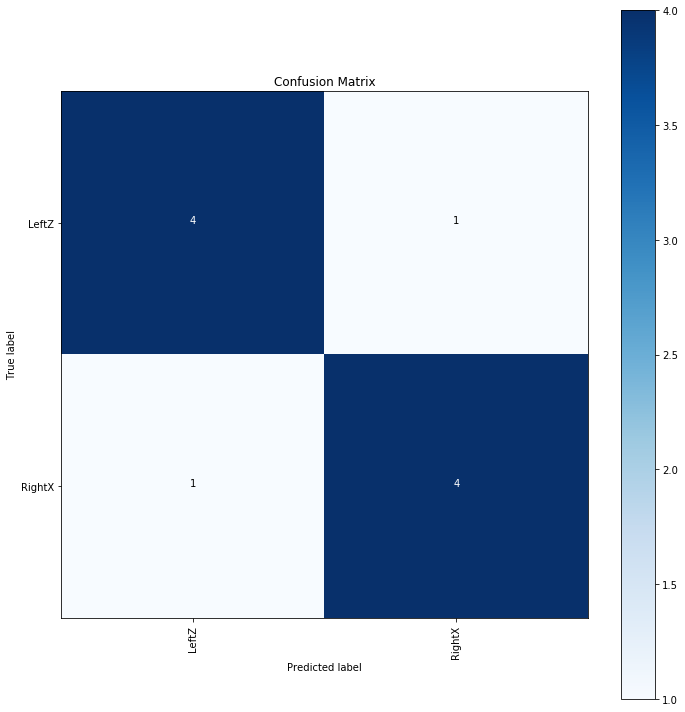

In [252]:
# This is the simplest possible SVM using only a few features but gives you a sense of the overall approach
# Some nice resources:
#  - A very simple classification example using scikit: 
#     https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  - Official sci-kit learn: http://scikit-learn.org/stable/modules/svm.html

from sklearn import svm
from sklearn.preprocessing import StandardScaler

import itertools



numFolds = 5
selected_gesture_set = get_gesture_set_with_str(setName)
numGestures = selected_gesture_set.get_num_gestures()
numTrialsTotal = selected_gesture_set.get_total_num_of_trials()

# Setting a seed here keeps producing the same folds set each time. Take that out
# if you want to randomly produce a fold set on every execution
foldToMapGestureToTrial = generate_kfolds(numFolds, selected_gesture_set.map_gestures_to_trials, seed=5)
mapGestureToCorrectMatches = dict()

y_true = []
y_pred = []

gestureNamesSorted = selected_gesture_set.get_gesture_names_sorted()
for gestureName in gestureNamesSorted:
    mapGestureToCorrectMatches[gestureName] = 0

for i in range(0, len(foldToMapGestureToTrial)):
    trainingFolds = foldToMapGestureToTrial.copy()
    testFold = trainingFolds.pop(i)
    
    trainingData = []
    classLabels = np.array([])
    
    # build training data for this set of folds
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            features = extract_features_example(trainingTrial)
            trainingData.append(features)
            classLabels = np.append(classLabels, trainingGestureName)

    # Here, we train SVM, the 'rbf' kernal is default
    # if you use rbf, need to set gamma and C parameters
    # play around with different kernels, read about them, and try them. What happens?
    # see: 
    # - https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
    # - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    clf = svm.SVC(kernel='rbf', gamma='scale') # kernel='linear'
#     clf = svm.SVC(kernel='linear') # kernel='linear'
   

     # Scale
    np_train = np.array(trainingData)
    scaler = StandardScaler()
    scaler.fit(np_train)
    np_train_scaled = scaler.transform(np_train)

#     clf.fit(np_train, classLabels) 
    clf.fit(np_train_scaled, classLabels) 
    
    # make predictions for this test set
    for testGestureName, testTrial in testFold.items():
        features = np.array(extract_features_example(testTrial))
        features_scaled = scaler.transform([features])
        svmPrediction = clf.predict(features_scaled)
#         svmPrediction = clf.predict([features])
        y_true.append(testGestureName)
        y_pred.append(svmPrediction)
        
        if testGestureName == svmPrediction[0]:
            mapGestureToCorrectMatches[testGestureName] += 1
                
totalCorrectMatches = 0
print("SVM Results:\n")
for gesture in mapGestureToCorrectMatches:
    c = mapGestureToCorrectMatches[gesture]
    print("{}: {}/{} ({}%)".format(gesture, c, numFolds, c / numFolds * 100))
    totalCorrectMatches += mapGestureToCorrectMatches[gesture]
    
print("\nTotal SVM classifier accuracy {:0.2f}%\n".format(totalCorrectMatches / numTrialsTotal * 100))

cm = confusion_matrix(y_true, y_pred, gestureNamesSorted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=gestureNamesSorted, title='Confusion Matrix')
plt.show()